In [1]:
from src.utils import fetch_data_from_db

In [2]:
query = "SELECT * FROM xdr_data"
df = fetch_data_from_db(query)

In [3]:
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


# Task 3.1
### Aggregate the number of xDR sessions, session duration and the total download (DL) and upload (UL) data for each application

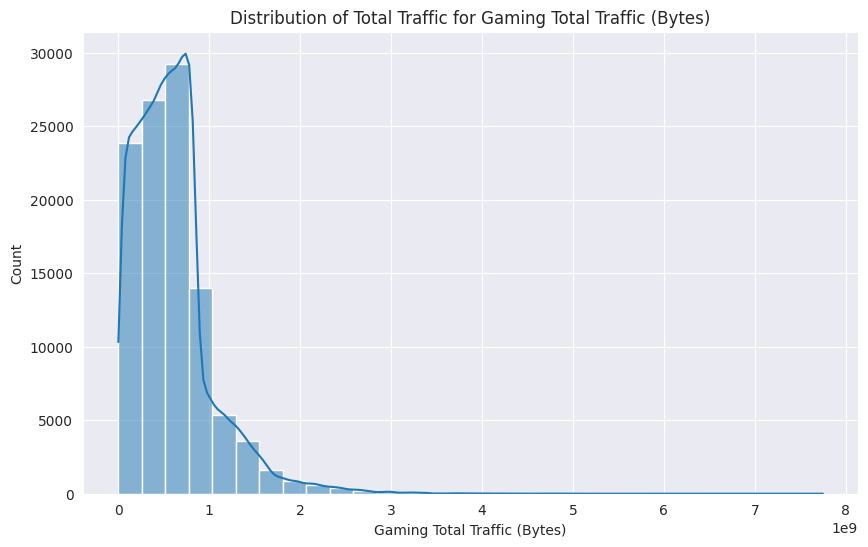

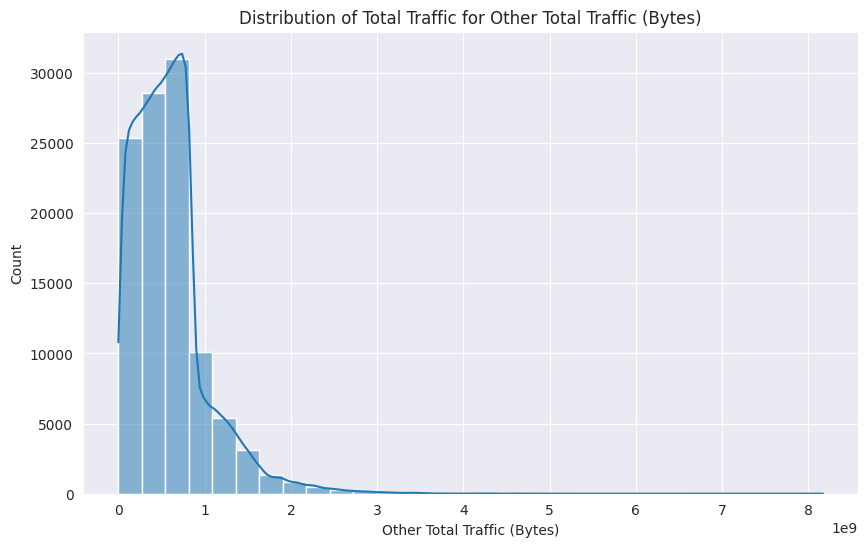

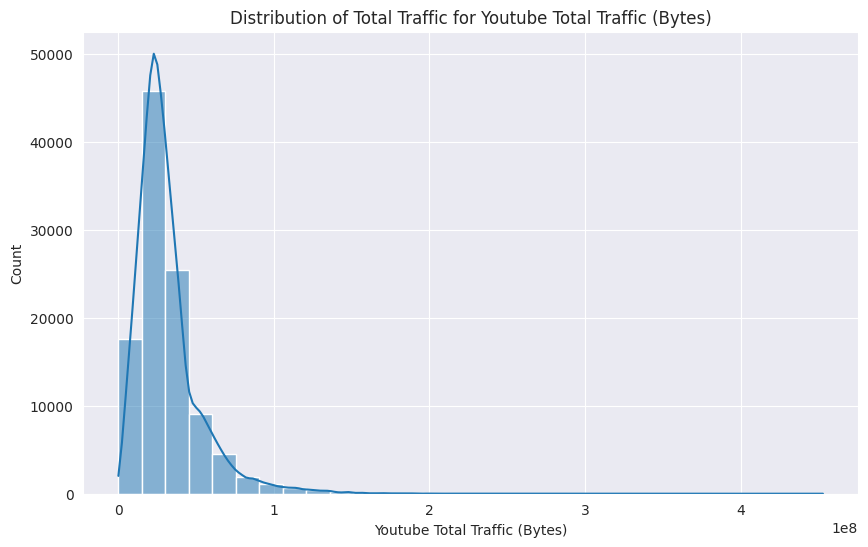

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate the engagement metrics per customer id (MSISDN)
df['Total Traffic (Bytes)'] = df['Total DL (Bytes)'] + df['Total UL (Bytes)']
engagement_metrics = df.groupby('MSISDN/Number').agg({'Bearer Id': 'count', 'Dur. (ms)': 'sum', 'Total Traffic (Bytes)': 'sum'})
engagement_metrics.columns = ['Session Frequency', 'Session Duration', 'Total Traffic']


#### Top 10 customers per engagement metric

In [ ]:

# Report the top 10 customers per engagement metric
top_10_customers = engagement_metrics.nlargest(10, ['Session Frequency', 'Session Duration', 'Total Traffic'])

# print the top 10 customers per engagement metric
top_10_customers

### Normalize the engagement metrics and run a k-means (k=3) to classify customers in three groups of engagement

In [ ]:

# Normalize each engagement metric
scaler = StandardScaler()
normalized_metrics = scaler.fit_transform(engagement_metrics)

# Run a k-means (k=3) to classify customers in three groups of engagement
kmeans = KMeans(n_clusters=3, random_state=0).fit(normalized_metrics)


### Compute the minimum, maximum, average & total non-normalized metrics for each cluster

In [ ]:

# Compute the minimum, maximum, average & total non-normalized metrics for each cluster
cluster_metrics = engagement_metrics.groupby(kmeans.labels_).agg(['min', 'max', 'mean', 'sum'])


### Aggregate user total traffic per application

In [ ]:

# Aggregate user total traffic per application
applications = ['Social Media', 'Youtube', 'Netflix', 'Google', 'Email', 'Gaming', 'Other']
for app in applications:
    df[f'{app} Total Traffic (Bytes)'] = df[f'{app} DL (Bytes)'] + df[f'{app} UL (Bytes)']
app_traffic = df.groupby('MSISDN/Number')[[f'{app} Total Traffic (Bytes)' for app in applications]].sum()


#### Top 10 users per application

In [ ]:

# Derive the top 10 most engaged users per application
top_10_users_per_app = app_traffic.apply(lambda x: x.nlargest(10).index.tolist())


In [ ]:

# Plot the top 3 most used applications
top_3_apps = app_traffic.sum().nlargest(3).index
for app in top_3_apps:
    plt.figure(figsize=(10, 6))
    sns.histplot(app_traffic[app], bins=30, kde=True)
    plt.title(f'Distribution of Total Traffic for {app}')
    plt.show()


In [ ]:

# Using k-means clustering algorithm, group users in k engagement clusters based on the engagement metrics
# Determine the optimized value of k using the elbow method
distortions = []
silhouettes = []
K = range(2, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(normalized_metrics)
    distortions.append(kmeanModel.inertia_)
    silhouettes.append(silhouette_score(normalized_metrics, kmeanModel.labels_))

# Plot the elbow
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# The optimal number of clusters is the value of k at the "elbow" ie. the point after which the distortion/inertia start decreasing in a linear fashion.